In [1]:
import os, sys, torch
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../scripts")

from yolo_speed_main import run_speed_estimation

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: True
GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [6]:
project_root = os.path.abspath("..")
input_dir = os.path.join(project_root, "data", "input_videos")
output_dir = os.path.join(project_root, "data", "output_videos")

pixels_per_meter = 1.5

videos = [v for v in os.listdir(input_dir) if v.lower().endswith(".avi")]
print(f"🎥 Total videos found: {len(videos)}\n")

for i, VIDEO_FILENAME in enumerate(videos, start=1):
    print(f"[{i}/{len(videos)}] Processing: {VIDEO_FILENAME}")

    video_path = os.path.join(input_dir, VIDEO_FILENAME)
    output_video_path = os.path.join(output_dir, VIDEO_FILENAME.replace(".avi", "_nb_out.mp4"))
    output_csv_path = os.path.join(output_dir, VIDEO_FILENAME.replace(".avi", "_nb_speeds.csv"))

    run_speed_estimation(
        video_path=video_path,
        output_video_path=output_video_path,
        output_csv_path=output_csv_path,
        yolo_model="yolov8n.pt",
        conf_thres=0.4,
        pixels_per_meter=pixels_per_meter,
    )

    print("Done.")

print("\nAll videos processed successfully!")

🎥 Total videos found: 254

[1/254] Processing: cctv052x2004080516x01638.avi
Using device: cuda
Video FPS: 10.0
Video size: 320 x 240
Video processing done. Output saved at: d:\Fareed\ml_projects\vehicle_speed_tracking\data\output_videos\cctv052x2004080516x01638_nb_out.mp4
Speed CSV saved at: d:\Fareed\ml_projects\vehicle_speed_tracking\data\output_videos\cctv052x2004080516x01638_nb_speeds.csv
   id  avg_speed_kmh
0   0      36.879837
1   1      39.059945
2   2      57.690237
3   3      10.745823
4   4      23.729919
Done.
[2/254] Processing: cctv052x2004080516x01639.avi
Using device: cuda
Video FPS: 10.0
Video size: 320 x 240
Video processing done. Output saved at: d:\Fareed\ml_projects\vehicle_speed_tracking\data\output_videos\cctv052x2004080516x01639_nb_out.mp4
Speed CSV saved at: d:\Fareed\ml_projects\vehicle_speed_tracking\data\output_videos\cctv052x2004080516x01639_nb_speeds.csv
   id  avg_speed_kmh
0   0      20.442533
1   1      13.959356
2   2      19.253539
3   3      44.69241

In [7]:
output_dir = r"D:\Fareed\ml_projects\vehicle_speed_tracking\data\output_videos"
csv_files = [f for f in os.listdir(output_dir) if f.endswith("_nb_speeds.csv")]

all_rows = []
for f in csv_files:
    video_name = f.replace("_nb_speeds.csv", "")
    df = pd.read_csv(os.path.join(output_dir, f))
    df["video"] = video_name
    all_rows.append(df)

merged_df = pd.concat(all_rows, ignore_index=True)
merged_path = os.path.join(output_dir, "all_vehicle_speeds.csv")
merged_df.to_csv(merged_path, index=False)

merged_df.head(), len(merged_df)

(   id  avg_speed_kmh                     video
 0   0      36.879837  cctv052x2004080516x01638
 1   1      39.059945  cctv052x2004080516x01638
 2   2      57.690237  cctv052x2004080516x01638
 3   3      10.745823  cctv052x2004080516x01638
 4   4      23.729919  cctv052x2004080516x01638,
 7181)

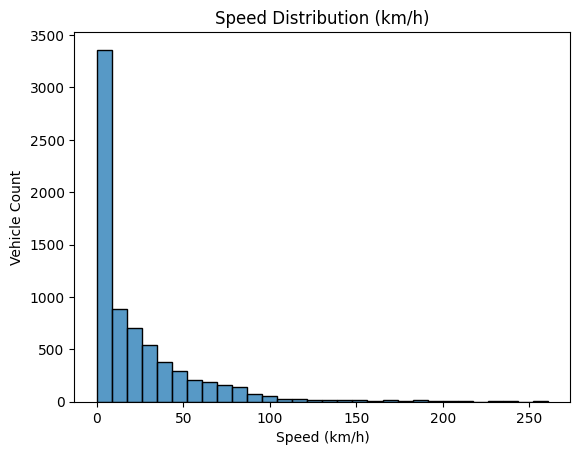

In [9]:
import seaborn as sns

sns.histplot(merged_df["avg_speed_kmh"], bins=30)
plt.title("Speed Distribution (km/h)")
plt.xlabel("Speed (km/h)")
plt.ylabel("Vehicle Count")
plt.show()


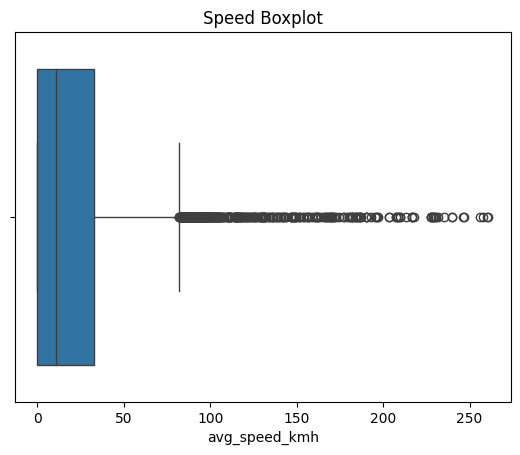

In [10]:
sns.boxplot(x=merged_df["avg_speed_kmh"])
plt.title("Speed Boxplot")
plt.show()

In [11]:
print("Mean speed:", merged_df["avg_speed_kmh"].mean())
print("Median speed:", merged_df["avg_speed_kmh"].median())
print("95th percentile:", merged_df["avg_speed_kmh"].quantile(0.95))
print("Vehicle count:", len(merged_df))

Mean speed: 23.08394480584673
Median speed: 10.901684850991955
95th percentile: 84.40354884268763
Vehicle count: 7181


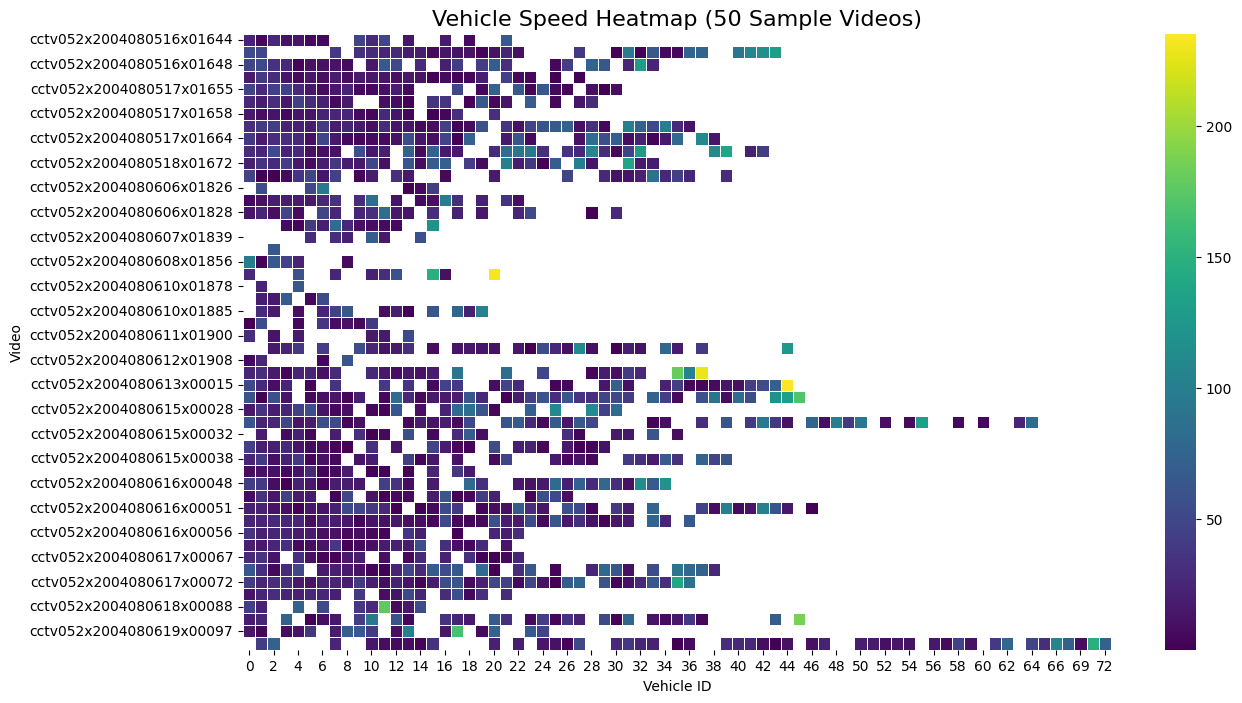

In [13]:
sample_videos = merged_df["video"].drop_duplicates().sample(50, random_state=42)
df_sample = merged_df[merged_df["video"].isin(sample_videos)]
df_sample = df_sample[df_sample["avg_speed_kmh"] > 0]

pivot_df = df_sample.pivot_table(
    index="video", columns="id", values="avg_speed_kmh", aggfunc="mean"
)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_df, cmap="viridis", linewidths=0.5)
plt.title("Vehicle Speed Heatmap (50 Sample Videos)", fontsize=16)
plt.xlabel("Vehicle ID")
plt.ylabel("Video")
plt.show()